# Predire il successo di una campagna Kickstarter
**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
a.a. 2020/2021  
Filippo Barbari matricola 0000874589

## Descrizione del problema e analisi esplorativa
In questo progetto, si vuole realizzare un modello capace di predire il successo o meno di una campagna Kickstarter. Una campagna Kickstarter è essenzialmente una raccolta fondi che una singola persona o un gruppo possono creare sul sito [Kickstarter](https://www.kickstarter.com) per finanziare un progetto. Per lanciare una campagna, è necessario darle un nome, fornire una descrizione, ma soprattutto specificare la somma di denaro che si intende raccogliere e la data entro cui lo si vuole fare. Non è possibile chiudere in anticipo la campagna oppure prolungarla.  
Tra le campagne Kickstarter più famose si ricordano Planetary Annihilation (videogioco di strategia in tempo reale per PC) che raccolse 2,228,000$ in 30 giorni e FrostHaven (un gioco da tavolo cooperativo) che ha raccolto oltre 13 milioni di dollari.  
Si vuole rendere il problema più realistico possibile utilizzando solamente i dati noti al momento del lancio della campagna come: la data di lancio, le categorie in cui rientra, la somma richiesta e la deadline prefissata.

Prima di tutto, importiamo le librerie necessarie.

In [207]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import math
from scipy import stats
%matplotlib inline

### Caricamento dati

Scarichiamo da GitHub il file `kickstarter.csv`. Il dataset originale è disponibile [qui](https://www.kaggle.com/yashkantharia/kickstarter-campaigns).

In [208]:
file_csv_url = "https://raw.githubusercontent.com/Ledmington/Progetto-Data-Intensive/master/Kickstarter_projects_Feb19.csv"
file_csv_name = "kickstarter.csv"

if not os.path.exists(file_csv_name):
    from urllib.request import urlretrieve
    urlretrieve(file_csv_url, file_csv_name)

In [209]:
with open(file_csv_name) as dataFile:
    data_raw = pd.read_csv(dataFile, sep=",")

print("Caricati {} record.".format(len(data_raw)))

Caricati 192548 record.


### Significato delle features

In [210]:
data_raw.head(1)

,id,name,currency,main_category,sub_category,launched_at,deadline,duration,goal_usd,city,state,country,blurb_length,name_length,status,start_month,end_month,start_Q,end_Q,usd_pledged
0,1687733153,Socks of Speed and Socks of Elvenkind,USD,games,Tabletop Games,2018-10-30 20:00:02,2018-11-15 17:59:00,16.0,2000.0,Menasha,WI,US,14,7,successful,10,11,Q4,Q4,6061.0


* `id` è un numero identificativo univoco di una campagna Kickstarter
* `name` è il nome della campagna Kickstarter
* `currency` è la valuta in cui era espressa la somma richiesta (l'ammontare è stato convertito in USD)
* `main_category` è la categoria principale del progetto riguardante la campagna
* `sub_category` è la categoria secondaria del progetto
* `launched_at` è la data e l'ora del lancio della campagna
* `deadline` è la data in cui viene chiusa la campagna
* `duration` è il numero di giorni trascorsi prima della chiusura della campagna
* `goal_usd` è la somma di denaro richiesta espressa in USD
* `city` è la città di appartenenza del gruppo che ha lanciato la campagna
* `state` è lo stato/regione di provenienza del gruppo che ha lanciato la campagna
* `country` è il paese di provenienza del gruppo che ha lanciato la campagna
* `blurb_length` è il numero di parole della descrizione della campagna
* `name_length` è il numero di parole del nome della campagna
* `status` è il risultato finale della campagna (la variabile che si vuole predire)
* `start_month` è il mese in cui è stata lanciata la campagna
* `end_month` è il mese in cui è terminata la campagna
* `start_Q` è il "quarter" (o trimestre) in cui è stata lanciata la campagna
* `end_Q` è il "quarter" (o trimestre) in cui è terminata la campagna
* `usd_pledged` è la somma di denaro effettivamente raccolta espressa in USD

Osserviamo l'occupazione iniziale in memoria dell'intero dataset. La confronteremo più avanti con la dimensione del dataset privato dei dati ridondanti o derivati.

In [211]:
data_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192548 entries, 0 to 192547
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             192548 non-null  int64  
 1   name           192548 non-null  object 
 2   currency       192548 non-null  object 
 3   main_category  192548 non-null  object 
 4   sub_category   192548 non-null  object 
 5   launched_at    192548 non-null  object 
 6   deadline       192548 non-null  object 
 7   duration       192548 non-null  float64
 8   goal_usd       192548 non-null  float64
 9   city           192548 non-null  object 
 10  state          192548 non-null  object 
 11  country        192548 non-null  object 
 12  blurb_length   192548 non-null  int64  
 13  name_length    192548 non-null  int64  
 14  status         192548 non-null  object 
 15  start_month    192548 non-null  int64  
 16  end_month      192548 non-null  int64  
 17  start_Q        192548 non-nul

### Eliminazione dati mancanti, inutili, ridondanti o derivati

Osserviamo subito che il dataset non contiene dati mancanti.

In [212]:
data_raw.isna().sum()

id               0
name             0
currency         0
main_category    0
sub_category     0
launched_at      0
deadline         0
duration         0
goal_usd         0
city             0
state            0
country          0
blurb_length     0
name_length      0
status           0
start_month      0
end_month        0
start_Q          0
end_Q            0
usd_pledged      0
dtype: int64

Eliminiamo le colonne `name`, `currency`, `blurb_length`, `name_length` perchè non sono utili ai fini di questo progetto.

In [213]:
data_raw.drop(labels=["name", "currency", "blurb_length", "name_length"], axis=1, inplace=True)

Eliminiamo la colonna `id` perchè è ridondante. Come identificativo dei record utilizzeremo l'index di default dei DataFrame Pandas.

In [214]:
data_raw.drop(labels=["id"], axis=1, inplace=True)

Eliminiamo le colonne `deadline`, `start_month`, `end_month`, `start_Q` e `end_Q` perchè sono dati derivati dalle colonne `launched_at` e `duration`. Qui scegliamo di utilizzare `duration`, ovvero la durata in giorni prefissata per la campagna, invece della data di fine, per semplificare il preprocessing delle feature.

In [215]:
data_raw.drop(labels=["deadline", "start_month", "end_month", "start_Q", "end_Q"], axis=1, inplace=True)

Eliminiamo la colonna `usd_pledged` perchè contiene la soluzione.

In [216]:
data_raw.drop(labels=["usd_pledged"], axis=1, inplace=True)

Le tre colonne categoriche `city`, `state` e `country` rappresentano un insieme di dati particolare. La colonna `state` rappresenta lo stato, per paesi come gli USA oppure il Regno Unito, oppure una regione per paesi come l'Italia. Tuttavia, alcuni paesi come la Germania, la Nuova Zelanda o l'Afghanistan, apparentemente, non sono suddivisi in questo modo e i record con riferimento a questi paesi hanno uguali valori di `city` e `state`. Per questo motivo, rimuoviamo la colonna `state`.  
Inoltre, come è possibile osservare dall'estratto riportato qui sotto, alcuni record presentano dati inconsistenti per quanto riguarda la colonna `country`. Ad esempio, il record 47 indica come città Kabul (capitale dell'Afghanistan) e come paese gli Stati Uniti. Un altro esempio, il record 74 indica come città Bangkok (capitale della Thailandia) e come paese la Francia. Crediamo che questa "inconsistenza" sia dovuto al fatto che Kickstarter permette la creazione di una campagna solamente se si possiede un conto bancario o carta di credito in un ristretto insieme di paesi. Per questo motivo, più della metà delle campagne Kickstarter risultano come se fossero state lanciate dagli US.  
Per evitare che tali inconsistenze possano in qualche modo alterare l'esito dell'addestramento dei modelli, abbiamo scelto di eliminare tutte e tre le colonne in questione.

In [217]:
(data_raw[data_raw["city"] == data_raw["state"]]).head()

,main_category,sub_category,launched_at,duration,goal_usd,city,state,country,status
7,design,Graphic Design,2018-07-17 21:36:14,30.0,1133.68788,Berlin,Berlin,DE,successful
47,journalism,Journalism,2012-05-04 23:35:02,5.0,500.00000,Kabul,Kabul,US,successful
74,photography,Places,2016-02-28 10:18:02,47.0,5668.43940,Bangkok,Bangkok,FR,successful
79,journalism,Journalism,2010-06-25 03:24:43,30.0,2200.00000,Istanbul,Istanbul,US,successful
96,publishing,Art Books,2016-11-13 00:35:29,22.0,800.00000,Vienna,Vienna,US,successful


In [218]:
data_raw.drop(labels=["city", "state", "country"], axis=1, inplace=True)

Infine, notiamo che `sub_category` assume 159 valori distinti. Questa esplosione di variabili binarie potrebbe influenzare negativamente il successo della modellazione. Inoltre, non è un dato completamente indipendente da `main_category` e per questo motivo, lo eliminiamo dal dataset.

In [219]:
data_raw["sub_category"].nunique()

159

In [220]:
data_raw.drop("sub_category", axis=1, inplace=True)

In [221]:
data_raw.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192548 entries, 0 to 192547
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   main_category  192548 non-null  object 
 1   launched_at    192548 non-null  object 
 2   duration       192548 non-null  float64
 3   goal_usd       192548 non-null  float64
 4   status         192548 non-null  object 
dtypes: float64(2), object(3)
memory usage: 40.7 MB


### Conversione dati

Creiamo `data`, una copia del dataset in cui andremo a "ripulire" i dati.  
Trasformiamo `main_category` e `status` in dati categorici.  
Trasformiamo `duration` in intero perchè rappresenta il numero di giorni di durata della campagna.

In [222]:
data = data_raw
data["main_category"] = data["main_category"].astype("category")
data["status"] = data["status"].astype("category")
data["duration"] = data["duration"].astype("int64")

Riguardo a `launched_at`, prima di tutto la trasformiamo in `datetime64` per poterla maneggiare meglio. Dopo di ciò, vogliamo estrapolare da essa il numero del giorno all'interno dell'anno (per fare si che, ad esempio, il primo gennaio risulti come 0 e il 31 dicembre risulti come 364). Per fare ciò, utilizziamo l'attributo `dayofyear` della classe `Timestamp` di Pandas e sottraiamo 1.

In [223]:
data["launched_at"] = data["launched_at"].astype("datetime64")
data["launched_at"] = pd.Series(x.dayofyear-1 for x in data["launched_at"]).astype("int64")

Infine, per maggiore chiarezza, rinomiamo `launched_at` in `launch_day` e `duration` in `days`.

In [224]:
data = data_raw.rename(columns={"launched_at" : "launch_day",
                                "duration": "days"})

Possiamo notare come la dimensione del dataset sia diminuita da circa 150MB iniziali a circa 5MB.

In [225]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192548 entries, 0 to 192547
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   main_category  192548 non-null  category
 1   launch_day     192548 non-null  int64   
 2   days           192548 non-null  int64   
 3   goal_usd       192548 non-null  float64 
 4   status         192548 non-null  category
dtypes: category(2), float64(1), int64(2)
memory usage: 4.8 MB


### Esplorazione singole features

La distribuzione dei record tra le varie `main_category` non è uniforme anche se non viè una grande differenza tra quelle più frequenti e quelle meno frequenti.

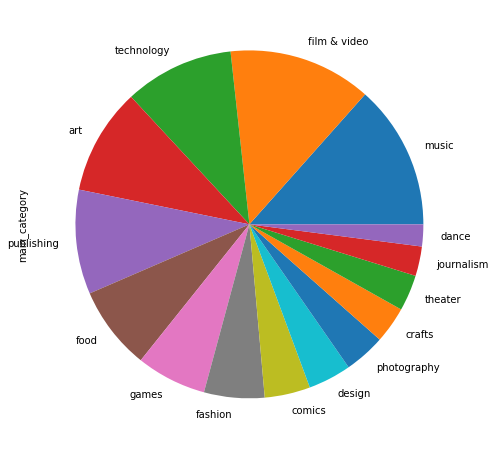

In [226]:
data["main_category"].value_counts().plot.pie(figsize=(8, 8));

Riguardo a `launch_date` notiamo che i dati sono distribuiti in maniera abbastanza uniforme, tranne per l'ultimo periodo dell'anno. Intorno agli ultimi 20 giorni dell'anno, troviamo circa la metà delle campagne rispetto agli altri periodi dell'anno.

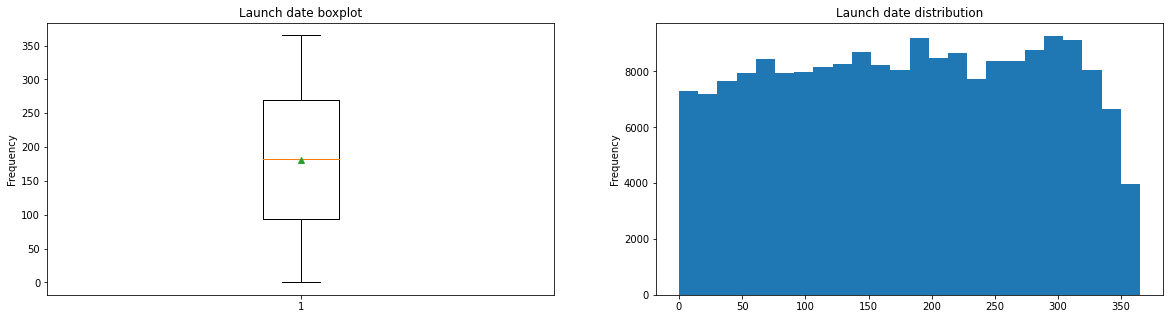

In [227]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axis[0].boxplot(data["launch_day"], showmeans=True)
axis[0].set_title("Launch date boxplot")
axis[0].set_ylabel("Frequency");

axis[1].hist(data["launch_day"], bins=24)
axis[1].set_title("Launch date distribution")
axis[1].set_ylabel("Frequency");

Come possiamo notare dai grafici riportati qui sotto, i dati all'interno di `days` sono estremamente sbilanciati in quanto più della metà dei valori sono 30. Nonostante ciò produca un boxplot con un elevato numero di outliers, questa informazione rispecchia un comportamento del tutto normale. Infatti, i dati confermano che sia molto comune aprire una campagna Kickstarter della durata di 30 giorni.

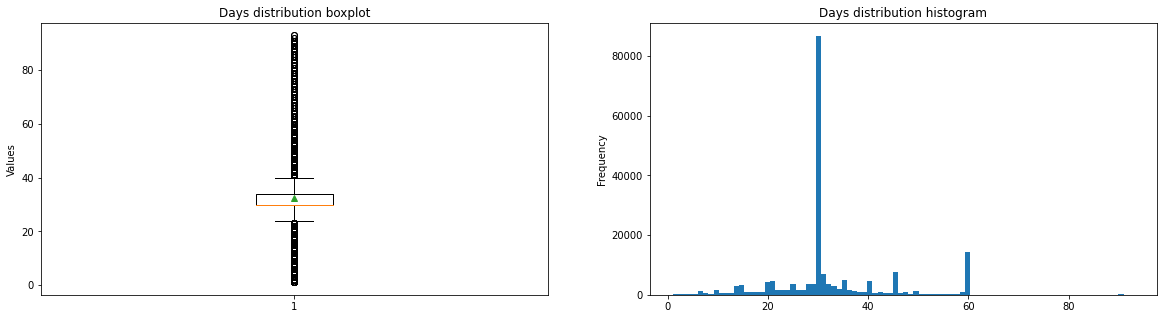

In [228]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axis[0].boxplot(data["days"], showmeans=True)
axis[0].set_title("Days distribution boxplot")
axis[0].set_ylabel("Values");

axis[1].hist(data["days"], bins=90)
axis[1].set_title("Days distribution histogram")
axis[1].set_ylabel("Frequency");

I valori di `goal_usd` non sono uniformemente distribuiti. Come possiamo notare dal grafico, nell'intervallo [0;500] e [33e3;12e6] sono presenti all'incirca lo stesso numero di valori. La maggior parte dei valori, infatti, pare essere concentrata all'incirca tra 500 e 5000 doliari.

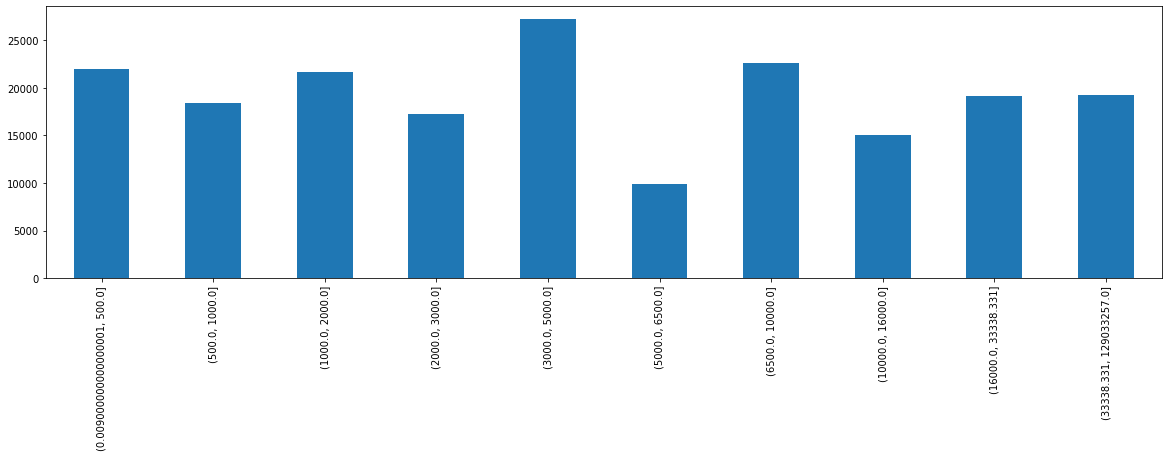

In [229]:
pd.qcut(data["goal_usd"], q=10).value_counts().sort_index().plot.bar(figsize=(20, 5));

Infine, possiamo notare che quasi due terzi dei record del dataset sono etichettati come "successful". Questa distribuzione andrà tenuta in considerazione in fase di modellazione.

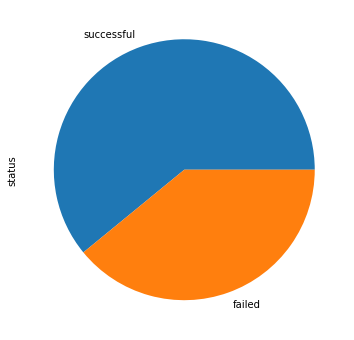

In [230]:
data["status"].value_counts().plot.pie(figsize=(6, 6));

### Esplorazione relazioni tra features

Vogliamo verificare se esiste una relazione tra `goal_usd` e `status`. E' ragionevole pensare che, all'aumentare della somma da raccogliere diminuisca la probabilità di successo di una campagna.  
Effettivamente, il numero di campagne fallite è pari o maggiore al numero di campagne completate nei due intervalli più a destra. Mentre le campagne completate risultano evidentemente maggiori in tutti gli altri intervalli, in particolar modo in quelli più a sinistra.

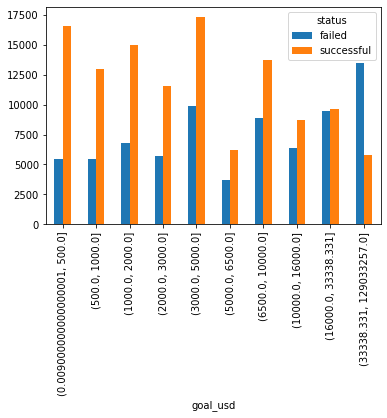

In [231]:
usd_over_status = data[["status", "goal_usd"]].copy()
usd_over_status.groupby([pd.qcut(usd_over_status["goal_usd"], q=10), "status"]).size().unstack("status").plot.bar();

Vogliamo verificare se esiste una relazione tra `status` e `days`. E' ragionevole pensare che, all'aumentare della durata di una campagna aumenti anche la probabilità di successo di tale campagna.  
I due grafici riportano all'incirca la stessa distribuzione. La maggiore frequenza di campagne completate era già stata osservata in precedenza.

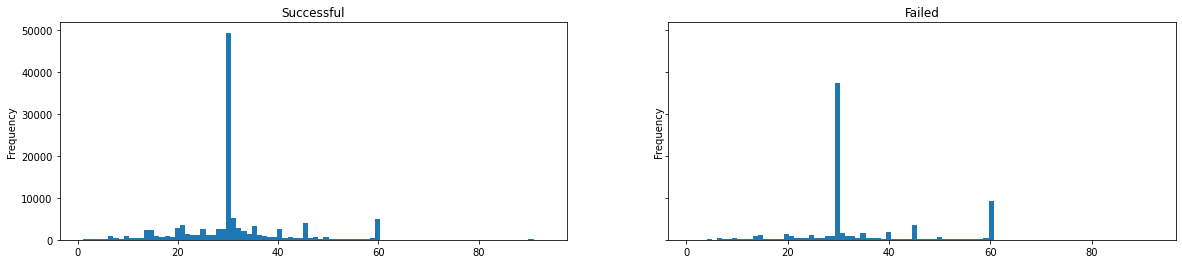

In [232]:
days_over_status = data[["status", "days"]].copy()
fig, axis = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 4));
axis[0].hist(days_over_status[days_over_status["status"]=="successful"]["days"], bins=90);
axis[0].set_ylabel("Frequency");
axis[0].set_title("Successful");
axis[1].hist(days_over_status[days_over_status["status"]=="failed"]["days"], bins=90);
axis[1].set_ylabel("Frequency");
axis[1].set_title("Failed");

Non esploriamo altre relazioni tra features perchè non abbiamo ragione di pensare che ve ne siano altre.

## Preparazione dati

Trasformiamo i dati categorici in variabili binarie. Per la colonna `status` trasformiamo "failed" in 0 e "successful" in 1.

In [233]:
main_category_dummies = data["main_category"].str.get_dummies()
data = data.merge(main_category_dummies, left_index=True, right_index=True);
data = data.drop(columns=["main_category"]);

binary_status = {"failed":0,
                 "successful":1}
tmp_status = pd.Series(binary_status[x] for x in data["status"])
data.drop("status", axis=1, inplace=True)
data.insert(data.shape[1], "status", tmp_status)

Separiamo la colonna `status`, ovvero la soluzione, dal resto del dataset.

In [234]:
status = data["status"].copy()
data.drop("status", axis=1, inplace=True)

### Suddivisione dataset
Qui dividiamo i dati in training e test che utilizzeremo per addestrare un semplice modello Perceptron.

In [235]:
X_pre_train, X_pre_val, y_pre_train, y_pre_val = train_test_split(data, status, test_size=0.3, random_state=42)

In [236]:
def fit_and_eval(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    print("Training set score: {}".format(model.score(X_train, y_train)))
    print("Test set score: {}".format(model.score(X_val, y_val)))

### Standardizzazione, regolarizzazione e multicolinearità

Andiamo ora ad effettuare alcune prove di addestramento, con un modello basato sull'algoritmo Perceptron, per osservare come varia il punteggio utilizzando standardizzazione e regolarizzazione.

In [237]:
model = Pipeline([
    ("model",  Perceptron(n_jobs=-1, random_state=42))
])
fit_and_eval(model, X_pre_train, y_pre_train, X_pre_val, y_pre_val)

Training set score: 0.6427739403337216
Test set score: 0.6414437808361465


Come possiamo notare dal punteggio ottenuto, il modello non pare essere affetto da overfitting e possiede una precisione superiore alle aspettative.  
Osserviamo una distribuzione molto ampia di valori dal minimo -2.072e4 al massimo 3.977e6.

In [238]:
pd.Series(model.named_steps["model"].coef_[0]).describe()

count    1.800000e+01
mean     3.260976e+05
std      1.008698e+06
min     -2.072783e+04
25%     -1.226500e+03
50%      5.427500e+03
75%      1.357525e+04
max      3.977439e+06
dtype: float64

Ora proviamo a ripetere lo stesso addestramento aggiungendo il filtro `StandardScaler`.

In [239]:
std_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron())
])
fit_and_eval(std_model, X_pre_train, y_pre_train, X_pre_val, y_pre_val)

Training set score: 0.5907273172432725
Test set score: 0.5913442395914481


In [240]:
pd.Series(std_model.named_steps["model"].coef_[0]).describe()

count    18.000000
mean     -2.068587
std       9.820326
min     -39.330147
25%      -2.608647
50%       0.561829
75%       0.990115
max       7.519357
dtype: float64

Stranamente, la precisione del modello è diminuita, ma i coefficienti sono contenuti all'interno di un intervallo molto più piccolo.
Proviamo ora ad aggiungere una penalità di tipo L1 per verificare se esistono alcune variabili ininfluenti.

In [241]:
std_pen_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model",  Perceptron(penalty="l1", alpha=0.0001))
])
fit_and_eval(std_pen_model, X_pre_train, y_pre_train, X_pre_val, y_pre_val)

Training set score: 0.6333884837108538
Test set score: 0.6314723448454946


Stranamente, lo score aumenta ma non abbastanza da superare il valore ottenuto senza standardizzazione e notiamo che 14 delle 18 variabili coinvolte nel modello sono state azzerate perchè ininfluenti.

In [242]:
print(pd.Series(std_pen_model.named_steps["model"].coef_[0]).describe())
print("\nVariabili azzerate: {}".format((std_pen_model.named_steps["model"].coef_[0] == 0).sum()))

count    18.000000
mean     -0.570738
std       1.856219
min      -6.799687
25%       0.000000
50%       0.000000
75%       0.000000
max       0.985618
dtype: float64

Variabili azzerate: 14


Se andiamo ad osservare nel dettaglio quali variabili sono state azzerate, notiamo che `launch_day`, ovvero il giorno dell'anno del lancio della campagna, risulta essere ininfluente. Ciò può essere spiegato dalla distribuzione molto uniforme di questa variabile che la rende "quasi" costante.  
Stranamente, anche la durata in giorni di una campagna sembra essere ininfluente. Infine, come avevamo previsto la variabile più importante, `goal_usd`, ha un fortissimo peso negativo sul successo di una campagna.  
Molte delle categorie risultano essere ininfluenti sul successo di una campagna. Questa informazione ci suggerisce uno sbilanciamento tra le classi oppure ad una "cattiva" distribuzione dei successi e fallimenti tra le varie classi.

In [243]:
pd.Series(std_pen_model.named_steps["model"].coef_[0], index=X_pre_train.columns).head(10)

launch_day      0.000000
days            0.000000
goal_usd       -6.799687
art             0.000000
comics          0.000000
crafts          0.000000
dance           0.000000
design          0.000000
fashion         0.000000
film & video    0.000000
dtype: float64

Osservando la correlazione di Pearson tra `launch_day`, `days` e le altre variabili coinvolte, non notiamo valori così sbilanciati da farci supporre una correlazione vera e propria. Per questo motivo, preferiamo non eliminare queste colonne anche se sembrano essere ininfluenti.

In [244]:
corr = data.corr("pearson")[["launch_day", "days"]]
corr[corr<1.0].describe()

,launch_day,days
count,17.000000,17.000000
mean,0.000798,-0.001037
std,0.015132,0.032790
min,-0.022948,-0.055236
25%,-0.011259,-0.026610
50%,-0.001941,-0.007885
75%,0.007793,0.018631
max,0.032520,0.079170


## Modellazione

Prepariamo due funzioni per automatizzare l'addestramento tramite una GridSearch e K-Fold cross validation.  
In questa funzione, a causa delle elevate dimensioni del dataset, si scelgono un centesimo delle righe del dataset casualmente prima di passarle alla funzione `train_test_split` per evitare tempi di addestramento molto lunghi. 

In [245]:
models = {}

def grid_search_kfold(model, grid, scoring=None):
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(model, grid, scoring=scoring, cv=k_fold, n_jobs=-1)

    sample_index = data.sample(frac=0.01, random_state=42).index
    X_train, X_val, y_train, y_val = train_test_split(data.iloc[sample_index], status.iloc[sample_index], test_size=0.3, random_state=42)

    grid_search.fit(X_train, y_train)
    train_score = grid_search.score(X_train, y_train)
    test_score = grid_search.score(X_val, y_val)

    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    print("Trainig set score: {}\n".format(train_score))
    print("Test set score: {}\n".format(test_score))
    print("Best parameters: {}\n".format(grid_search.best_params_))
    return grid_search.best_estimator_, train_score, test_score

### Perceptron
Addestriamo nuovamente un modello basato su Perceptron sfruttando stavolta una GridSearch su:
 - standardizzazione dei dati
 - tipo di regolarizzazione/penalizzazione
 - coefficiente di regolarizzazione
 - utilizzo dell'intercetta

In [246]:
%%time
per_model = Pipeline([
    ("scaler", StandardScaler()),
    ("per", Perceptron(n_jobs=-1, random_state=42))
])

per_grid = {
    "scaler": [None, StandardScaler()],
    "per__penalty": ["l2", "l1", "elasticnet"],
    "per__alpha": np.logspace(-3, 3, 7),
    "per__fit_intercept": [False, True]
}

per_model, train_score, test_score = grid_search_kfold(per_model, per_grid)
models["Perceptron"] = {"model": per_model,
                        "train_accuracy": train_score,
                        "test_accuracy": test_score}

Best cross validation score: 0.6116453256230208

Trainig set score: 0.4669636228656273

Test set score: 0.4671280276816609

Best parameters: {'per__alpha': 0.01, 'per__fit_intercept': True, 'per__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

CPU times: user 808 ms, sys: 22.4 ms, total: 831 ms
Wall time: 2.82 s


### Logistic Regression
La Logistic Regression è un algoritmo per ottenere un iperpiano di separazione non ottimale ma lineare. Effettuiamo una GridSearch su:
 - standardizzazione dei dati
 - tipo di regolarizzazione/penalizzazione
 - il parametro C, l'inverso del coefficiente di regolarizzazione
 - utilizzo dell'intercetta

In [247]:
%%time
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver='liblinear', random_state=42))
])

log_grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1", "elasticnet"],
    "lr__C": np.logspace(-4, 2, 7),
    "lr__fit_intercept": [False, True]
}

log_model, train_score, test_score = grid_search_kfold(log_model, log_grid)
models["Logistic Regression"] = {"model": log_model,
                                 "train_accuracy": train_score,
                                 "test_accuracy": test_score}

Best cross validation score: 0.682965716646014

Trainig set score: 0.6852264291017075

Test set score: 0.671280276816609

Best parameters: {'lr__C': 1.0, 'lr__fit_intercept': True, 'lr__penalty': 'l2', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

CPU times: user 770 ms, sys: 69.2 ms, total: 839 ms
Wall time: 3.43 s


### Support Vector Machines

Support Vector Machines è un algoritmo di classificazione che determina l'iperpiano di separazione ottimale. In particolare, trasforma lo spazio in cui sono definiti i dati di input in modo che tali dati diventino linearmente separabili. Effettuiamo una GridSearch su:
 - il tipo di kernel function da utilizzare
 - il parametro C che consente di controllare l'overfitting

In [248]:
%%time
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(random_state=42))
])

svm_grid = {
  "svc__kernel": ["linear", "rbf"],
  "svc__C": np.logspace(1, 3, 3)
}

svm_model, train_score, test_score = grid_search_kfold(svm_model, svm_grid)
models["Support Vector Machines"] = {"model": svm_model,
                                     "train_accuracy": train_score,
                                     "test_accuracy": test_score}

Best cross validation score: 0.6740547982927165

Trainig set score: 0.6792873051224945

Test set score: 0.6539792387543253

Best parameters: {'svc__C': 10.0, 'svc__kernel': 'linear'}

CPU times: user 1.38 s, sys: 143 ms, total: 1.53 s
Wall time: 2min 52s


### K-Neighbors Classifier

K-Nearest Neighbors (anche noto come kNN) è un algoritmo di classificazione molto semplice che tende ad aggregare i dati classificandoli mediante un voto di maggioranza dei $k$ punti più vicini. Effettuiamo una GridSearch su:
 - standardizzazione dei dati
 - numero di punti vicini da considerare
 - il tipo di funzione da utilizzare per scegliere i punti "vicini"

In [249]:
%%time
knc_model = Pipeline([
    ("scaler", StandardScaler()),
    ("knc", KNeighborsClassifier(n_jobs=-1))
])

knc_grid = {"scaler": [None, StandardScaler()],
            'knc__n_neighbors': range(1, 10, 1),
            'knc__weights': ['uniform', 'distance']}

knc_model, train_score, test_score = grid_search_kfold(knc_model, knc_grid)
models["K-Neighbors"] = {"model": knc_model,
                         "train_accuracy": train_score,
                         "test_accuracy": test_score}

Best cross validation score: 0.6547514801046399

Trainig set score: 0.9992576095025983

Test set score: 0.643598615916955

Best parameters: {'knc__n_neighbors': 9, 'knc__weights': 'distance', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

CPU times: user 833 ms, sys: 15.8 ms, total: 849 ms
Wall time: 11 s


### Decision Tree

Il Decision Tree è un modello creato deducendo semplici regole di decisione dai dati in input. Effettuiamo una GridSearch su:
 - standardizzazione dei dati
 - numero minimo di record necessario per ramificare un nodo interno
 - numero minimo di record necessario per considerare valida una foglia
 - profondità massima dell'albero
 - massimo numero di features da considerare

In [250]:
%%time
tree_model = Pipeline([
    ("scaler", StandardScaler()),
    ("tree", DecisionTreeClassifier(random_state=42))
])

tree_grid = {"scaler": [None, StandardScaler()],
             'tree__min_samples_split': range(2, 4, 1),
             'tree__min_samples_leaf': range(1, 4, 1), 
             'tree__max_depth': [None] + [i for i in range(2, 7)],
             'tree__max_features': range(2, data.columns.size, 1)}

tree_model, train_score, test_score = grid_search_kfold(tree_model, tree_grid)
models["Decision Tree"] = {"model": tree_model,
                           "train_accuracy": train_score,
                           "test_accuracy": test_score}

Best cross validation score: 0.6925953462756438

Trainig set score: 0.7119524870081663

Test set score: 0.6626297577854672

Best parameters: {'scaler': None, 'tree__max_depth': 4, 'tree__max_features': 8, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 2}

CPU times: user 7.61 s, sys: 77 ms, total: 7.69 s
Wall time: 30 s


### Random Forest

Random Forest è un algoritmo di ensemble learning che costituisce un'evoluzione dei Decision Tree. Infatti, realizza un insieme di alberi decisionali indipendenti il cui risultato viene poi combinato mediante un voto. Effettuiamo una GridSearch sugli stessi iperparametri dei Decision Tree più il numero di alberi decisionali da utilizzare.

In [251]:
%%time
forest_model = Pipeline([
    ("scaler", StandardScaler()),
    ("forest", RandomForestClassifier(n_jobs=-1, random_state=42))
])

forest_grid = {"scaler": [None, StandardScaler()],
             'forest__n_estimators': range(5, 10),
             'forest__min_samples_split': range(2, 5), 
             'forest__max_depth': [None] + [i for i in range(1, 3)],
             'forest__max_features': [int(math.sqrt(data.columns.size)), data.columns.size - 1]}

forest_model, train_score, test_score = grid_search_kfold(forest_model, forest_grid)
models["Random Forest"] = {"model": forest_model,
                           "train_accuracy": train_score,
                           "test_accuracy": test_score}

Best cross validation score: 0.6643783560512185

Trainig set score: 0.6592427616926503

Test set score: 0.6349480968858131

Best parameters: {'forest__max_depth': 2, 'forest__max_features': 17, 'forest__min_samples_split': 2, 'forest__n_estimators': 5, 'scaler': None}

CPU times: user 6.11 s, sys: 234 ms, total: 6.34 s
Wall time: 1min 37s


### Riepilogo risultati

Notiamo che i valori di accuratezza dei modelli non sono molto alti. In particolare, i modelli SVM, K-Neighbors e Decision Tree risultano essere palesemente in **overfitting**. Per questo motivo, li eliminiano dalla lista dei modelli e non li considereremo oltre.

In [252]:
accuracy_df = pd.DataFrame([
                            [name, model["train_accuracy"], model["test_accuracy"]]
                            for name,model in models.items()
                           ],
                           columns=["Name", "Training accuracy", "Test accuracy"]).set_index("Name")
accuracy_df

,Training accuracy,Test accuracy
Name,,
Perceptron,0.466964,0.467128
Logistic Regression,0.685226,0.671280
Support Vector Machines,0.679287,0.653979
K-Neighbors,0.999258,0.643599
Decision Tree,0.711952,0.662630
Random Forest,0.659243,0.634948


In [253]:
[models.pop(k) for k in ["Support Vector Machines", "K-Neighbors", "Decision Tree"]]

[{'model': Pipeline(memory=None,
           steps=[('scaler',
                   StandardScaler(copy=True, with_mean=True, with_std=True)),
                  ('svc',
                   SVC(C=10.0, break_ties=False, cache_size=200,
                       class_weight=None, coef0=0.0,
                       decision_function_shape='ovr', degree=3, gamma='scale',
                       kernel='linear', max_iter=-1, probability=False,
                       random_state=42, shrinking=True, tol=0.001,
                       verbose=False))],
           verbose=False),
  'test_accuracy': 0.6539792387543253,
  'train_accuracy': 0.6792873051224945},
 {'model': Pipeline(memory=None,
           steps=[('scaler',
                   StandardScaler(copy=True, with_mean=True, with_std=True)),
                  ('knc',
                   KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                        metric='minkowski', metric_params=None,
                                

## Valutazione modelli di classificazione

L'accuratezza può non essere una buona stima della capacità predittiva di un modello di classificazione, in particolare nei casi in cui il dataset è sbilanciato. In questo caso se si costruisse un modello che predica sempre una campagna Kickstarter come "successful", questo avrebbe un'accuratezza del 60%.

In [254]:
X_train, X_val, y_train, y_val = train_test_split(data, status, test_size=0.3, random_state=42)
y_val.value_counts(normalize=True)

1    0.607513
0    0.392487
Name: status, dtype: float64

### Confronto con un modello casuale

"Addestrando" un modello casuale notiamo che l'accuratezza risulta intorno al 50%, del tutto comprensibile dal momento che la variabile da predire è binaria. Dunque, scartiamo il Perceptron che possiede una precisione inferiore del DummyClassifier.

In [255]:
random_model = DummyClassifier(strategy="uniform", random_state=42)
random_model.fit(X_train, y_train)
random_score = random_model.score(X_val, y_val)
models["Dummy"] = {"model" : random_model, "score": random_score}
random_score

0.4989007184281139

In [256]:
[models.pop(k) for k in ["Dummy", "Perceptron"]];

### Precision, Recall, F1-Score

Andiamo ora a misurare Precision, Recall e F1-Score per ogni modello e per ogni classe da predire.

In [257]:
def model_metrics(name, X, y) :
    model = models[name]
    y_pred = model["model"].predict(X)
    
    model["pr_success"] = precision_score(y, y_pred, average="binary", pos_label=1)
    model["pr_failed"]  = precision_score(y, y_pred, average="binary", pos_label=0)
    model["precision"]  = precision_score(y, y_pred, average="macro")

    model["r_success"] = recall_score(y, y_pred, average="binary", pos_label=1)
    model["r_failed"]  = recall_score(y, y_pred, average="binary", pos_label=0)
    model["recall"]    = recall_score(y, y_pred, average="macro")

    model["f1_success"] = f1_score(y, y_pred, average="binary", pos_label=1)
    model["f1_failed"] = f1_score(y, y_pred, average="binary", pos_label=0)
    model["f1_score"] = f1_score(y, y_pred, average="macro")

    return pd.Series({
        "Name":name,
        "Training accuracy":model["train_accuracy"],
        "Test accuracy":model["test_accuracy"],
        "Pr(success)":model["pr_success"],
        "Pr(failed)":model["pr_failed"],
        "Precision":model["precision"],
        "R(success)":model["r_success"],
        "R(failed)":model["r_failed"],
        "Recall":model["recall"],
        "F1(success)":model["f1_success"],
        "F1(failed)":model["f1_failed"],
        "F1-Score":model["f1_score"]
    })

Com'era prevedibile, entrambi i modelli ottengono risultati migliori sulle campagne "successful" rispetto a quelle "failed".  
Il modello Logistic Regression ottiene valori più alti sia in Precision e Recall, sia in F1-Score.

In [258]:
models_df = pd.DataFrame(model_metrics(name, X_val, y_val) for name,model in models.items())
models_df.set_index("Name", inplace=True)
models_df

,Training accuracy,Test accuracy,Pr(success),Pr(failed),Precision,R(success),R(failed),Recall,F1(success),F1(failed),F1-Score
Name,,,,,,,,,,,
Logistic Regression,0.685226,0.671280,0.688007,0.627613,0.657810,0.843673,0.407816,0.625744,0.757929,0.494386,0.626158
Random Forest,0.659243,0.634948,0.662685,0.572292,0.617489,0.834696,0.342361,0.588528,0.738811,0.428426,0.583618


### Confronto con intervallo di confidenza
Per verificare la rilevanza statistica del punteggio F1, effettuiamo un confronto con intervallo di confidenza tra Logistic Regressione e Random Forest. Utilizziamo un valore di confidenza del 95%.

In [259]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))

logreg_error = 1 - models["Logistic Regression"]["f1_score"]
forest_error = 1 - models["Random Forest"]["f1_score"]

difference_between_two_models(logreg_error, forest_error, 0.95)

Valore minimo: 0.03781228638282471
Valore massimo: 0.0472665140131752



In [260]:
models.pop("Random Forest")
logreg = models["Logistic Regression"]

Proviamo ad effettuare un undersampling dei dati per bilanciare le classi da predire e ri-addestriamo il modello Logistic Regression per vedere se ciò può migliorarlo ulteriormente.

In [261]:
ratio = 1 - status.value_counts()[0] / status.value_counts()[1]
sample_index = status.loc[status==1].sample(frac=ratio, random_state=42).index
data.drop(labels=sample_index, inplace=True)
status.drop(labels=sample_index, inplace=True)
data.reset_index(drop=True, inplace=True)
status.reset_index(drop=True, inplace=True)
status.value_counts()

1    75241
0    75241
Name: status, dtype: int64

In [262]:
%%time
log_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(solver='liblinear', random_state=42))
])

log_grid = {
    "scaler": [None, StandardScaler()],
    "lr__penalty": ["l2", "l1"],
    "lr__C": np.logspace(-4, 2, 7),
    "lr__fit_intercept": [False, True]
}

log_model, train_score, test_score = grid_search_kfold(log_model, log_grid)
models["Logistic Regression balanced"] = {"model" : log_model, "train_accuracy": train_score, "test_accuracy": test_score}

Best cross validation score: 0.6362446400361093

Trainig set score: 0.6562203228869895

Test set score: 0.6482300884955752

Best parameters: {'lr__C': 100.0, 'lr__fit_intercept': True, 'lr__penalty': 'l1', 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

CPU times: user 650 ms, sys: 19.3 ms, total: 669 ms
Wall time: 2.17 s


In [263]:
models_df = pd.DataFrame(model_metrics(name, X_val, y_val) for name,model in models.items())
models_df.set_index("Name", inplace=True)
models_df

,Training accuracy,Test accuracy,Pr(success),Pr(failed),Precision,R(success),R(failed),Recall,F1(success),F1(failed),F1-Score
Name,,,,,,,,,,,
Logistic Regression,0.685226,0.67128,0.688007,0.627613,0.65781,0.843673,0.407816,0.625744,0.757929,0.494386,0.626158
Logistic Regression balanced,0.656220,0.64823,0.730976,0.551585,0.64128,0.677486,0.614061,0.645773,0.703215,0.581149,0.642182


Come possiamo notare, l'accuratezza si è ridotta considerevolmente. Anche la Precision è calata a causa di una grande riduzione della Precision riguardante le campagne "failed". Allo stesso modo, la Recall riguardante le campagne "failed" è aumentata di molto. Infine, l'F1-Score è aumentato anche se non in maniera considerevole.

## Conclusioni
In questo progetto si è esplorata la possibilità di predire il successo di una campagna Kickstarter a partire dalla categoria, dalla data di lancio, dalla durata e dalla somma di denaro richiesta. Come abbiamo potuto constatare, il modello migliore si è rivelato essere la Logistic Regression che, purtroppo, raggiunge un'accuratezza del 67%. Questo valore è decisamente troppo basso per permettere l'utilizzo di questo modello per una vera e propria previsione.